In [54]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate

HEIGHT = 256
WIDTH = 256

In [64]:
# Load jpg image with file path
def decode_jpg(file_path):
    jpg = tf.io.read_file(file_path)
    jpg = tf.io.decode_jpeg(jpg, channels=3)
    return jpg

# Load png image with file path
def decode_png(file_path):
    png = tf.io.read_file(file_path)
    png = tf.io.decode_png(png, channels=1)
    return png

# Return image and its corresponding mask
def process_path(image_fp, mask_fp):
    image = decode_jpg(image_fp)
    mask = decode_png(mask_fp)
    return image, mask

    
# Resize images to 256*256
def resize_images(image, mask):
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image[np.newaxis, :, :,:]
    image = image/255
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = mask[np.newaxis, :, :,:]
    mask = tf.math.round(mask/255)
    return image, mask

# Create dataset given folder name
def create_dataset(inputs, outputs):
    ds  = tf.data.Dataset.from_tensor_slices((inputs, outputs))
    ds = ds.map(process_path)
    ds = ds.map(resize_images)
    return ds

# Plot one pair of image and mask in the given dataset
def plot_image(ds):
    for image, mask in ds.take(1):
        plt.figure()
        plt.imshow(image[0])
        plt.figure()
        plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

# Get the dice similarity coefficient
def get_dsc(predictions, truth):
    dsc = 2 * sum(predictions.flatten() == truth.flatten())/(2*len(predictions.flatten()))
    return dsc

def plot_comparation(predictions, true_masks):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2, 4, 2*i+1)   
        plt.imshow(predictions[i+16, :,:,:])
        plt.subplot(2, 4, 2*i+2)
        plt.imshow(true_masks[i+16, :,:,:])
    plt.show()

# Load validation dataset to numpy array
def load_masks(ds):
    true_masks = []
    for x, y in test_ds:
        true_masks.append(y[0,:,:,:])
    true_masks = np.array(true_masks)
    return true_masks

In [62]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate


def improved_unet(W, H):
    input_size = (W, H, 3)
    inputs = Input(input_size)
    print(inputs)
    #W*H*16
    conv1 = conv2D(16, 3, activation = tf.keras.layers.LeakyReLU(alpha=0.01), padding = 'same')(inputs)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv1)
    cont1 = Dropout(0.3)(cont1)
    cont1 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont1)
    conc1 = Add()([conv1, cont1]) #W*H*16
    # W/2 * H/2 * 32
  
    conv2 = conv2D(32, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc1)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv2)
    cont2 = Dropout(0.3)(cont2)
    cont2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont2)
    conc2 = Add()([conv2, cont2]) #W/2*H/2*32

    conv3 = conv2D(64, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc2)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv3)
    cont3 = Dropout(0.3)(cont3)
    cont3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont3)
    conc3 = Add()([conv3, cont3]) #W/4*H/4*64

    conv4 = conv2D(128, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc3)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv4)
    cont4 = Dropout(0.3)(cont4)
    cont4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont4)
    conc4 = Add()([conv4, cont4]) #W/8*H/8*128
 
    conv5 = conv2D(256, 3, strides = (2,2), activation = LeakyReLU(alpha=0.01), padding = 'same')(conc4)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(conv5)
    cont5 = Dropout(0.3)(cont5)
    cont5 = conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(cont5)
    conc5 = Add()([conv5, cont5]) #W/16*H/16*256

    uconv5 = UpSampling2D(size = (2,2))(conc5)
    uconv5 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv5)
 
    uconv4 = concatenate([uconv5, conc4])
    lconv4 = conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
    lconv4 = conv2D(128, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv4)
    uconv4 = UpSampling2D(size = (2,2))(uconv4)
    uconv4 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv4)
 
    uconv3 = concatenate([uconv4, conc3])
    lconv3 = conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)
    lconv3 = conv2D(64, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3)
    sconv3 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv3) 
    sconv3 = UpSampling2D(size = (2,2))(sconv3) 
    uconv3 = UpSampling2D(size = (2,2))(lconv3)
    uconv3 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv3)

    uconv2 = concatenate([uconv3, conc2])   
    lconv2 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    lconv2 = conv2D(32, 1, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2)
    sconv2 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(lconv2) 
    sconv2 = Add()([sconv2, sconv3])
    sconv2 = UpSampling2D(size = (2,2))(lconv2)
    uconv2 = UpSampling2D(size = (2,2))(uconv2)
    uconv2 = conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv2)
    
    uconv1 = concatenate([uconv2, conc1])
    uconv1 = conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1)
    sconv1 = conv2D(1, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(uconv1) 
    sconv1 = Add()([sconv1, sconv2])
    output = conv2D(1, 1, activation = 'sigmoid')(sconv1)
    model = Model(inputs = inputs, outputs = output)
    return model


In [59]:
def load_data():
    input_images = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/input/*.jpg"))
    output_masks = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/truth/*.png"))
    
    # Separate file names to train, validation and test.
    DATASET_SIZE = len(input_images)
    train_size = int(DATASET_SIZE * 0.7)
    val_size = test_size = int(DATASET_SIZE * 0.15)
    train_x = input_images[0:train_size]
    train_y = output_masks[0:train_size]
    test_x = input_images[train_size:train_size+test_size]
    test_y = output_masks[train_size:train_size+test_size]
    val_x = input_images[train_size+test_size:]
    val_y = output_masks[train_size+test_size:]
    
    # Create dataset given file names
    train_ds = create_dataset(train_x, train_y)
    test_ds = create_dataset(test_x, test_y)
    val_ds = create_dataset(val_x, val_y)
    
    # Plot image
    plot_image(train_ds)
    plot_image(test_ds)
    plot_image(val_ds)
    return train_ds, test_ds, val_ds

Tensor("input_2:0", shape=(None, 256, 256, 3), dtype=float32)
Train for 50 steps, validate for 20 steps
Epoch 1/50
50/50 [==============================] - 13s 263ms/step - loss: 0.5556 - acc: 0.7501 - val_loss: 0.5454 - val_acc: 0.7136
Epoch 2/50
50/50 [==============================] - 6s 123ms/step - loss: 0.4547 - acc: 0.8415 - val_loss: 0.4773 - val_acc: 0.7726
Epoch 3/50
50/50 [==============================] - 2s 49ms/step - loss: 0.3924 - acc: 0.8340 - val_loss: 0.4518 - val_acc: 0.7377
Epoch 4/50
50/50 [==============================] - 6s 129ms/step - loss: 0.5459 - acc: 0.8354 - val_loss: 0.4840 - val_acc: 0.7883
Epoch 5/50
50/50 [==============================] - 2s 48ms/step - loss: 0.4195 - acc: 0.8249 - val_loss: 0.6073 - val_acc: 0.6411
Epoch 6/50
50/50 [==============================] - 3s 52ms/step - loss: 0.4727 - acc: 0.8111 - val_loss: 4.4011 - val_acc: 0.7728
Epoch 7/50
50/50 [==============================] - 3s 50ms/step - loss: 0.4224 - acc: 0.8236 - val_loss: 

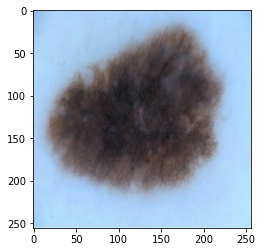

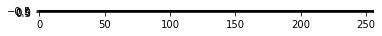

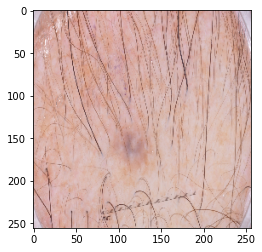

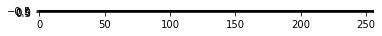

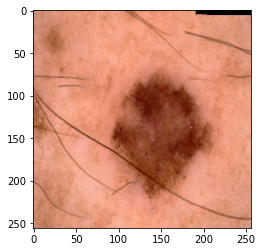

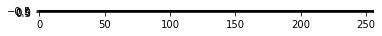

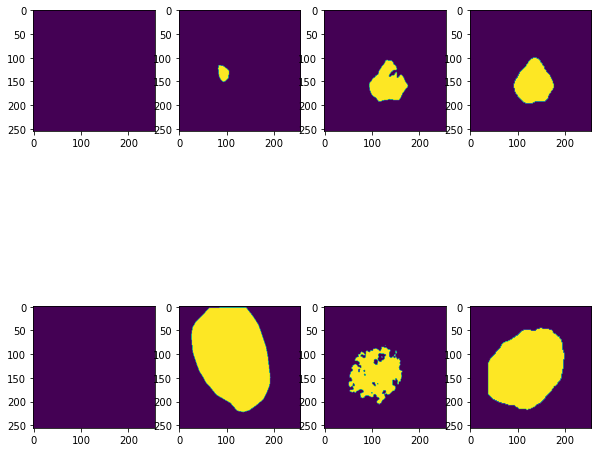

In [63]:



def main():
    train_ds, test_ds, val_ds = load_data()
    model = improved_unet(HEIGHT, WIDTH)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # Create check point
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        save_best_only=True)
    # Compile model
    history = model.fit(train_ds.repeat(), epochs = 50, steps_per_epoch=50, validation_data = val_ds, validation_steps=20, callbacks=[model_checkpoint_callback])
    # Evaluate test dataset
    results = model.evaluate(test_ds)
    print("test loss, test acc:", results)
    predictions = model.predict(test_ds)
    print(type(predictions))
    predictions = np.round(predictions)
    true_masks = load_masks(test_ds)
    dsc = get_dsc(predictions, true_masks)
    print('Dice similarity coefficient: ' + str(dsc))
    plot_comparation(predictions, true_masks)

main()


Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)


Train for 50 steps, validate for 20 steps
Epoch 1/50
50/50 [==============================] - 14s 279ms/step - loss: 0.5524 - acc: 0.7376 - val_loss: 0.5062 - val_acc: 0.7728
Epoch 2/50
50/50 [==============================] - 4s 70ms/step - loss: 0.4902 - acc: 0.8290 - val_loss: 0.4715 - val_acc: 0.7745
Epoch 3/50
50/50 [==============================] - 4s 85ms/step - loss: 0.3410 - acc: 0.8557 - val_loss: 0.6176 - val_acc: 0.7502
Epoch 4/50
50/50 [==============================] - 2s 46ms/step - loss: 0.6578 - acc: 0.8296 - val_loss: 0.6000 - val_acc: 0.7217
Epoch 5/50
50/50 [==============================] - 3s 52ms/step - loss: 0.5056 - acc: 0.8340 - val_loss: 0.5485 - val_acc: 0.6766
Epoch 6/50
50/50 [==============================] - 3s 51ms/step - loss: 0.6873 - acc: 0.7491 - val_loss: 0.4888 - val_acc: 0.7400
Epoch 7/50
50/50 [==============================] - 4s 90ms/step - loss: 0.3770 - acc: 0.8380 - val_loss: 1.3661 - val_acc: 0.5273
Epoch 8/50
50/50 [=====================

389/389 [==============================] - 62s 160ms/step - loss: 0.4009 - acc: 0.8539
[0.40089408416004135, 0.8538748]


(389, 256, 256, 1)
(389, 256, 256, 1)


0.8538744615098811


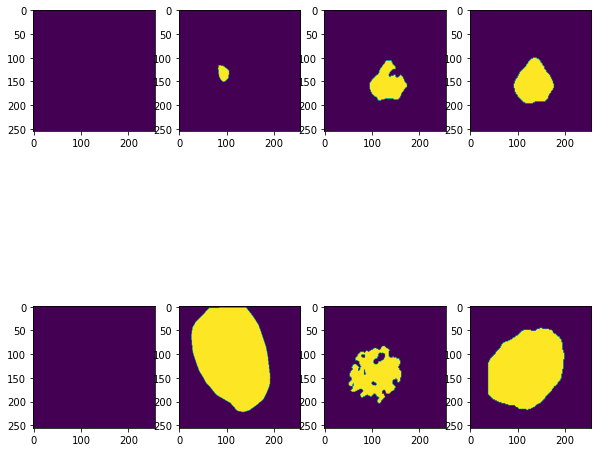

[0. 1.]
